## Importing

In [65]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


## Variable Preparation

In [66]:
def variable_preparation (ds, ds_bio):

    # Driver variables
    temp = ds.votemper
    saline = ds.vosaline
    e3t = ds.e3t

    # Biological variables
    sil = ds_bio.silicon
    nitr = ds_bio.nitrate
    ammo = ds_bio.ammonium

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()

    # Applying the mask
    temp = temp.where(mask==1)
    saline = saline.where(mask==1)
    e3t = e3t.where(mask==1)

    sil = sil.where(mask==1)
    nitr= nitr.where(mask==1)
    ammo = ammo.where(mask==1)

    # Integrating the variables
    temp_i1 = (temp[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15)
    temp_i2 = (temp[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12)
    saline_i1 = (saline[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15)
    saline_i2 = (saline[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12)

    sil_i = (sil[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27)
    nitr_i = (nitr[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27)
    ammo_i = (ammo[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27)


    return (temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i)

## SOM

In [67]:
def som (temp_i1, temp_i2, saline_i1, saline_i2):

    # Post processing 
    inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    )
    
    return (clusters, unique)

## Plotting Temperature and Salinity

In [68]:
def plotting0 (var1, var2, var3, var4, date):
    
    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')
    var1.plot.pcolormesh(ax=ax[0,0], cmap=cmap, cbar_kwargs={'label': 'Conservative Temperature [degree_C m-1]'})
    var2.plot.pcolormesh(ax=ax[0,1], cmap=cmap, cbar_kwargs={'label': 'Conservative Temperature [degree_C m-1]'})
    var3.plot.pcolormesh(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': 'Reference Salinity [g kg-1 m-1]'})
    var4.plot.pcolormesh(ax=ax[1,1], cmap=cmap, cbar_kwargs={'label': 'Reference Salinity [g kg-1 m-1]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
    
    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Conservative Temperature (0m - 15m)')
    ax[0,1].title.set_text('Conservative Temperature (15m - 100m)')
    ax[1,0].title.set_text('Reference Salinity (0m - 15m)')
    ax[1,1].title.set_text('Reference Salinity (15m - 100m)')

    fig.suptitle(str(date[0].year) + '/' + month + '/' + day)


## Plotting

In [69]:
def plotting (var1, var2, var3, var4, unique, date):
    
    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('tab10', unique.max()+1)
    cmap.set_bad('gray')
    clus = var1.plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique)
    cbar.set_label('Clusters [count]')

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')
    var2.plot.pcolormesh(ax=ax[0,1], cmap=cmap, cbar_kwargs={'label': 'Silicon Concentration [mmol m-2]'})
    var3.plot.pcolormesh(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': 'Nitrate Concentration [mmol m-2]'})
    var4.plot.pcolormesh(ax=ax[1,1], cmap=cmap, cbar_kwargs={'label': 'Ammonium Concentration [mmol m-2]'})

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clusters')
    ax[0,1].title.set_text('Silicon')
    ax[1,0].title.set_text('Nitrate')
    ax[1,1].title.set_text('Ammonium')

    fig.suptitle(str(date[0].year) + '/' + month + '/' + day)


## Main Body

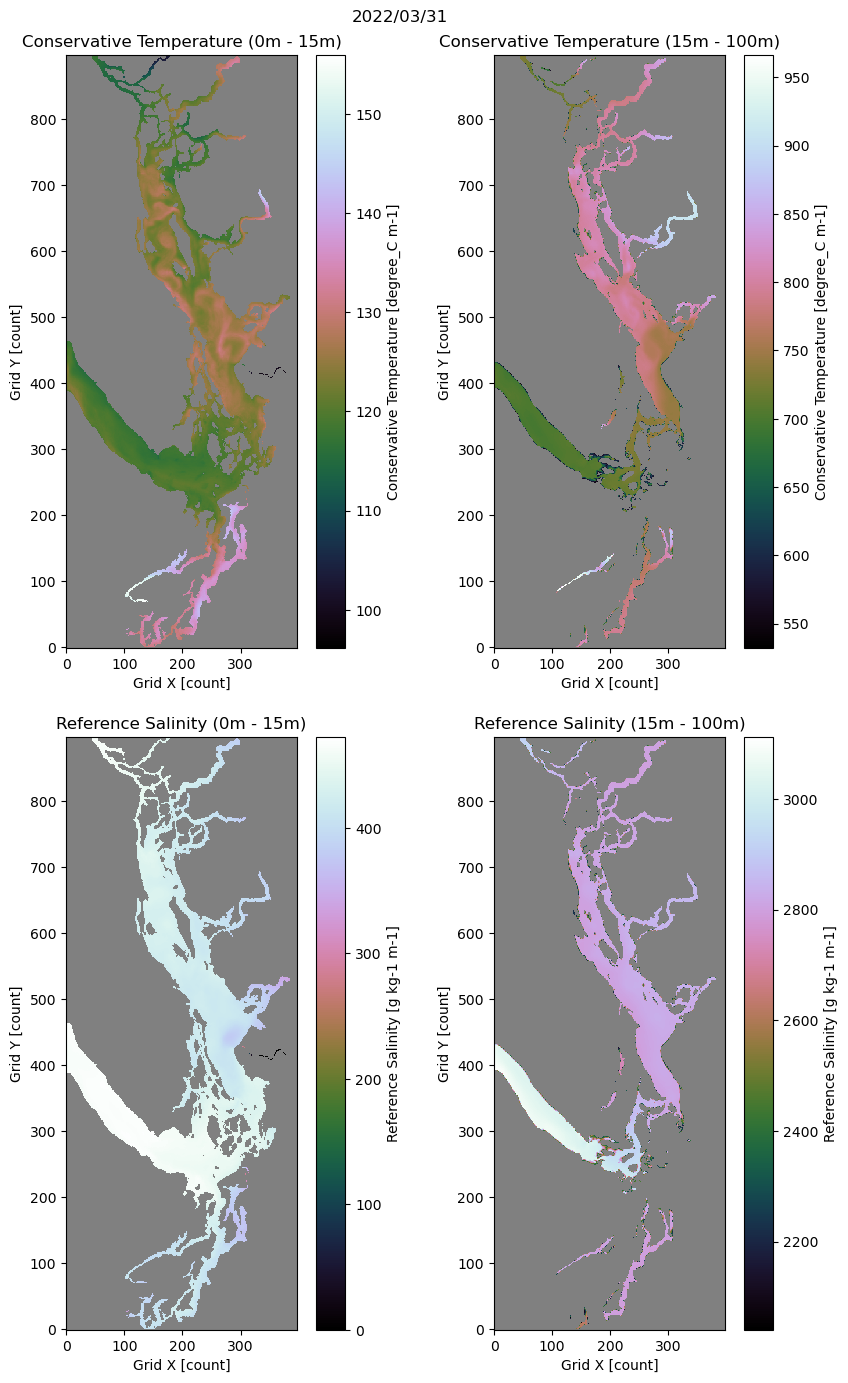

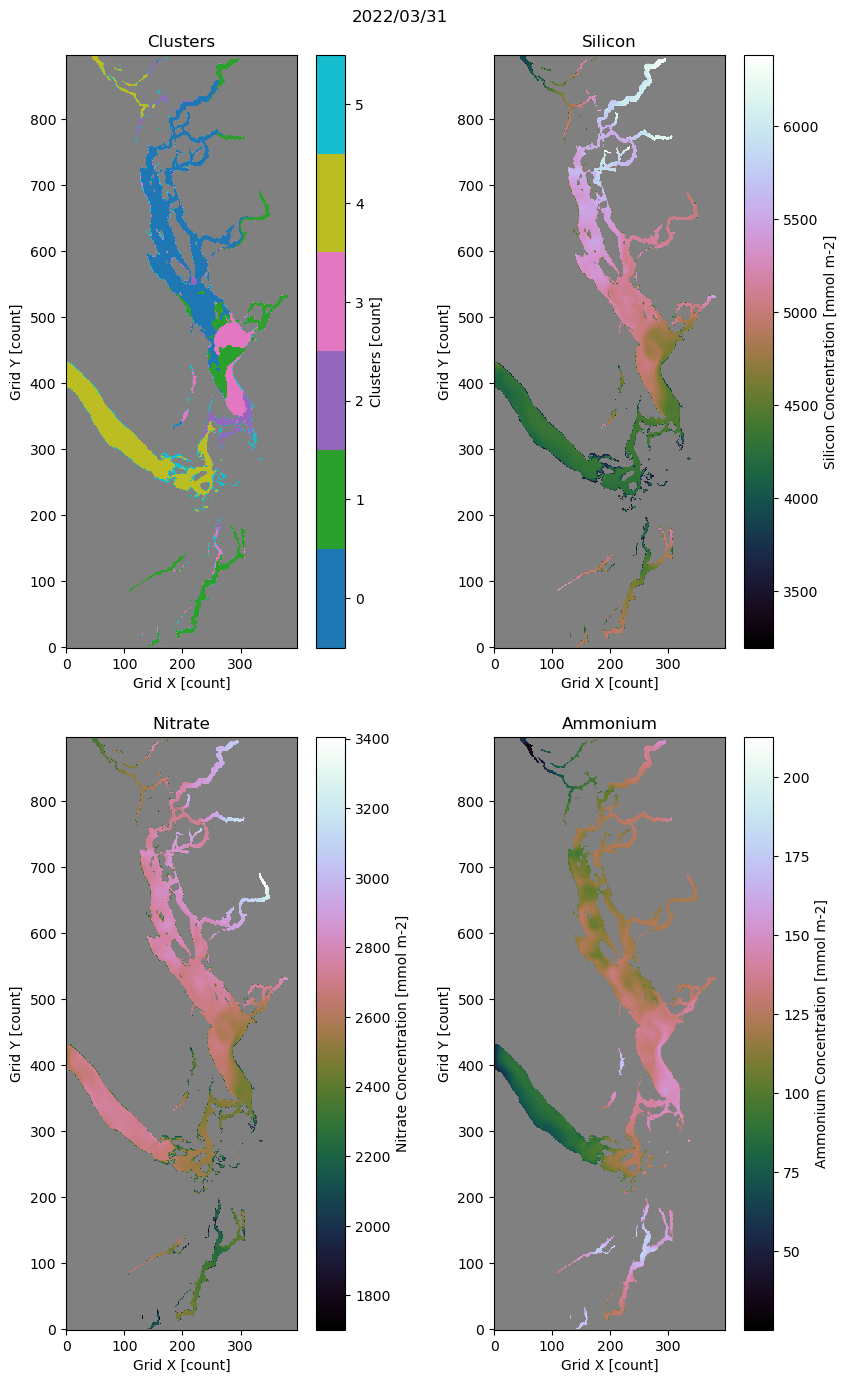

In [70]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i = variable_preparation(ds,ds_bio)

clusters, unique = som(temp_i1, temp_i2, saline_i1, saline_i2)

plotting0 (temp_i1, temp_i2, saline_i1, saline_i2, date)
plotting (clusters, sil_i, nitr_i, ammo_i, unique, date)